In [41]:
'''
╔═══════════════════════════════════════════════╗
║    SCC0251 - Image Processing and Analysis    ║
║    Year: 2024                  1º Semester    ║
╟───────────────────────────────────────────────╢
║      Student:  Fernando Gonçalves Campos      ║
║      Nº USP:   12542352                       ║
╟───────────────────────────────────────────────╢
║                 Assignment 3:                 ║
║       Color & Segmentation & Morphology       ║
╚═══════════════════════════════════════════════╝
'''

'''
Notes about my implementations:
Mixing this with the function implementations wouldn't make much sence :).

Erosion and Dilation:
    - Both functions were implemented by shifting the image so that the kernel cells overlap with the corresponding "kernel origin" on the image. That can
      be interpreted as looping through the entire image one time for each kernel cell. I implemented in this way since it achieved a better performance than
      the more intuitive approach (numpy doens't seem to have a 2d convolution function, and pure python is slow).

    - The functions were made to match the scikit functions for any kernel, not only a 3x3 square.
    - They have the same output for any 3x3 kernel, but I wasn't able achieve the same for other sizes (presumably because of different origin choices).

    - "Padding" was added to handle image pixels that would require (based on the structuring element) another pixel to be outside the image bounds.
    - The images were "padded" by repeating the edges, this was made to achieve the same output as scikit. However, "padding" the erosion with 'True'
      and the dilation with 'False' has the same outcome using a 3x3 square structuring element.

Otsu:
    - The function was implemented by maximizing the inter region variance. This achieved a significantly better performance.

    - The final outcome is missing the optimal threshold for the runcodes cases by one. The same happens when using the scikit implementation. Since this
      might have passed unnoticed during the creation of the test cases I decide to leave my results matching the scikit outputs.

Other functions:
    - I made some changes to the reference functions, they still are doing the same thing.
'''

import numpy as np
import imageio.v3 as imageio
from numpy.lib.stride_tricks import sliding_window_view


In [42]:
def filter_gaussian(height: int, width: int) -> np.ndarray:
    #Compute distances from upper left edge
    vertical_distances, horizontal_distances = np.ogrid[0:height, 0:width]

    #Compute distances from central position
    vertical_center = height / 2
    horizontal_center = width / 2
    vertical_distances = vertical_distances - vertical_center
    horizontal_distances = horizontal_distances - horizontal_center

    #Computes the gaussian filter
    x: np.ndarray = np.square(vertical_distances)/(2 * np.square(height)) + np.square(horizontal_distances)/(2 * np.square(width))
    return np.exp(-x)

#Visible spectrum
heatmap_colors: np.ndarray = np.array([
    [1, 0, 1],   # Pink
    [0, 0, 1],   # Blue
    [0, 1, 0],   # Green
    [1, 1, 0],   # Yellow
    [1, 0, 0]    # Red
])

def map_values_to_colors(values: np.ndarray, colormap: np.ndarray) -> np.ndarray:
    '''
    Map values to colors.
    '''
    min_val = np.min(values)
    max_val = np.max(values)

    # Scale the image to the range [0, len(colormap) - 1]
    scaled_values: np.ndarray = (values - min_val) * ((len(colormap) - 1) / (max_val - min_val))

    # Determine the two closest colors in the colormap
    limit: int = len(colormap) - 1
    idx1: np.ndarray = scaled_values.astype(np.uint16)
    idx2: np.ndarray = idx1 + 1
    idx2[idx2 > limit] = limit

    # Interpolate between the two colors based on the fractional part
    frac: np.ndarray = (scaled_values - idx1).reshape((*values.shape, 1))
    colored_image: np.ndarray = (1 - frac) * colormap[idx1] + frac * colormap[idx2]
    return colored_image

def rms_error(img: np.ndarray, out: np.ndarray) -> float:
    height, width = img.shape
    error = np.sqrt((np.sum(np.square(img-out))/(height * width)))
    return error

In [43]:
from skimage import morphology

def erosion(image: np.ndarray, kernel: np.ndarray, test: bool = False) -> np.ndarray:
    '''
    Erodes a binary image using a specified kernel.

    Args:
        image (np.ndarray): The binary image.
        kernel (np.ndarray): The structuring element.

    Returns:
        np.ndarray: The eroded image.
    '''
    if test:
        return morphology.erosion(image,kernel)

    image_height, image_width = image.shape

    # Only returns the pixels that fit for all kernel cells (checked using AND operator)
    new_image: np.ndarray = np.full((image_height, image_width), True)

    kernel_height, kernel_width = kernel.shape
    vertical_center: int = kernel_height // 2
    horizontal_center: int = kernel_width // 2

    # Loops through every cell of the kernel
    for y in range(kernel_height):
        # Direction and distance that the image will be rolled vertically
        y_roll: int = vertical_center - y

        # Determines the ranges that were outside the original image (replaced with the edge of the image)
        y_fill_ranges: tuple[int,int] = (0,y_roll) if y_roll >= 0 else (y_roll,image_height)

        for x in range(kernel_width):
            # Direction and distance that the image will be rolled horizontally
            x_roll: int = horizontal_center - x

            # Determines the ranges that were outside the original image (replaced with the edge of the image)
            x_fill_ranges: tuple[int,int] = (0,x_roll) if x_roll >= 0 else (x_roll,image_width)

            #Tests whether the cell is in the kernel
            if kernel[y,x]:
                rolled_image: np.ndarray = np.copy(image)

                # Vertical roll
                if y_roll != 0:
                    fill_value: np.ndarray = rolled_image[0,:] if y_roll > 0 else rolled_image[-1,:]
                    rolled_image: np.ndarray = np.roll(image, y_roll, axis=0)
                    rolled_image[y_fill_ranges[0]:y_fill_ranges[1], :] = fill_value

                # Horizontal roll
                if x_roll != 0:
                    fill_value: np.ndarray = rolled_image[:,0] if x_roll > 0 else rolled_image[:,-1]
                    rolled_image = np.roll(rolled_image, x_roll, axis=1)
                    rolled_image[:, x_fill_ranges[0]:x_fill_ranges[1]] = fill_value.reshape(image_height, 1)

                new_image &= rolled_image

    return new_image

def dilation(image: np.ndarray, kernel: np.ndarray, test: bool = False) -> np.ndarray:
    '''
    Dilates a binary image using a specified kernel.

    Args:
        image (np.ndarray): The binary image.
        kernel (np.ndarray): The structuring element.

    Returns:
        np.ndarray: The dilated image.
    '''
    if test:
        return morphology.dilation(image, kernel)

    image_height, image_width = image.shape

    # Only returns the pixels that fit for any of the kernel cells (checked using OR operator)
    new_image: np.ndarray = np.full((image_height, image_width), False)

    kernel_height, kernel_width = kernel.shape
    vertical_center: int = kernel_height // 2
    horizontal_center: int = kernel_width // 2

    # Loops through every cell of the kernel
    for y in range(kernel_height):
        # Direction and distance that the image will be rolled vertically
        y_roll: int = vertical_center - y

        # Determines the ranges that were outside the original image (replaced with the edge of the image)
        y_fill_ranges: tuple[int,int] = (0,y_roll) if y_roll >= 0 else (y_roll,image_height)

        for x in range(kernel_width):
            # Direction and distance that the image will be rolled horizontally
            x_roll: int = horizontal_center - x

            # Determines the ranges that were outside the original image (replaced with the edge of the image)
            x_fill_ranges: tuple[int,int] = (0,x_roll) if x_roll >= 0 else (x_roll,image_width)

            #Tests whether the cell is in the kernel
            if kernel[y,x]:
                rolled_image: np.ndarray = np.copy(image)

                # Vertical roll
                if y_roll != 0:
                    fill_value: np.ndarray = rolled_image[0,:] if y_roll > 0 else rolled_image[-1,:]
                    rolled_image: np.ndarray = np.roll(image, y_roll, axis=0)
                    rolled_image[y_fill_ranges[0]:y_fill_ranges[1], :] = fill_value

                # Horizontal roll
                if x_roll != 0:
                    fill_value: np.ndarray = rolled_image[:,0] if x_roll > 0 else rolled_image[:,-1]
                    rolled_image = np.roll(rolled_image, x_roll, axis=1)
                    rolled_image[:, x_fill_ranges[0]:x_fill_ranges[1]] = fill_value.reshape(image_height, 1)

                new_image |= rolled_image

    return new_image

def otsu(image: np.ndarray) -> int:
    '''
    Calculates the optimal threshold to divide a gray scale image in two regions. The threshold is calculated by maximizing the variance between both regions.

    Args:
        image (np.ndarray): The gray scale image for which is desired to compute the best binary threshold.

    Returns:
        int: The optimal threshold value (inclusive for the darker region and exclusive for the lighter region)
    '''
    #Image dimensions
    height, width = image.shape
    image_size: int = height * width

    #Number of pixels with each value
    hist, _ = np.histogram(image, bins = 256, range = (0, 256), density = False)

    #Total number of pixels in each region of the image
    dark_weight: int = 0
    light_weight: int = image_size

    #Total sum of the values in each region of the image
    dark_sum: int = 0
    light_sum: int = np.sum(image)

    #Variables for keeping track of the best values computed
    optimal_threshold: int = 0
    max_inter_var: int = -1

    for threshold in range(0, 255):
        #Count and total sum of the pixels that have the same values as the threshold
        cur_weight: int = hist[threshold]
        cur_sum: int = threshold * cur_weight

        #"Pass" the values that match the current threshold from the lighter region to the darker region
        dark_weight += cur_weight
        light_weight -= cur_weight
        dark_sum += cur_sum
        light_sum -= cur_sum

        #Prevents division by zero when either region is "empty"
        if dark_weight == 0 or light_weight == 0:
            continue

        #Computes the mean value for each region
        dark_mean: float = dark_sum / dark_weight
        light_mean: float = light_sum / light_weight

        #Computes the inter region variance
        cur_inter_var: float = dark_weight * light_weight * np.square(light_mean - dark_mean)

        #Save the cur thershold in case it's better then the previous best
        if max_inter_var <= cur_inter_var:
            optimal_threshold = threshold
            max_inter_var = cur_inter_var

    return optimal_threshold

In [44]:
def main(caseFileName: str) -> tuple[float, np.ndarray, np.ndarray]:
    input = open(caseFileName).readline

    import numpy as np
    import imageio.v3 as imageio

    #Read the inputs
    image_filename: str = input().rstrip('\r\n')
    ref_image_filename: str = input().rstrip('\r\n')
    technique_indexes_text: str = input().rstrip(' \r\n')
    technique_indexes: list[int] = [int(x)-1 for x in technique_indexes_text.split(' ')]

    #Read the image
    image: np.ndarray = imageio.imread(image_filename).astype(np.uint16)

    #Converts the image to gray scale
    gray_image: np.ndarray = image
    if len(image.shape) == 3:
        gray_image = np.dot(gray_image, [0.2989, 0.5870, 0.1140]).astype(np.uint16)

    #Applies thresholding to the image to get the binary mask
    optimal_threshold: int = otsu(gray_image)
    binary_mask: np.ndarray = gray_image > optimal_threshold + 1
    # ref_mask: np.ndarray = gray_image > optimal_threshold

    #Applies the techniques to the binary mask
    techniques = (erosion, dilation)
    kernel: np.ndarray = np.array([
        [True , True , True ],
        [True , True , True ],
        [True , True , True ]
    ])
    for i in technique_indexes:
        binary_mask = techniques[i](binary_mask, kernel)
    # for i in technique_indexes:
    #     ref_mask = techniques[i](ref_mask, kernel, True)


    #Creates the colored_mask
    color_distribution: np.ndarray = filter_gaussian(*gray_image.shape)
    colored_mask: np.ndarray = map_values_to_colors(color_distribution, heatmap_colors)
    colored_mask[binary_mask] = 1

    #Mix the grayscale image and the heatmap image
    gray_image = gray_image / np.max(gray_image)
    mixed_image: np.ndarray = 0.7 * gray_image.reshape((*gray_image.shape, 1)) + 0.3 * colored_mask
    mixed_image *= 255
    mixed_image = mixed_image.astype(np.uint16)

    #Read the reference image
    ref_image: np.ndarray = imageio.imread(ref_image_filename).astype(np.uint16)

    #Calculates the error
    error_R: float = rms_error(mixed_image[:,:,0], ref_image[:,:,0])
    error_G: float = rms_error(mixed_image[:,:,1], ref_image[:,:,1])
    error_B: float = rms_error(mixed_image[:,:,2], ref_image[:,:,2])
    error: float = (error_R + error_G + error_B) / 3

    #print(f"{error:.4f}")

    # return error, binary_mask, ref_mask
    return error, mixed_image, ref_image

 ==============Case1==============
 -----output----- ----expected----
      3.8854           0.0000     


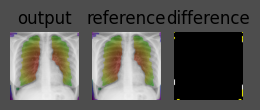

 ==============Case2==============
 -----output----- ----expected----
      2.2100           0.0000     


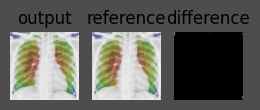

 ==============Case3==============
 -----output----- ----expected----
      2.2189           0.0000     


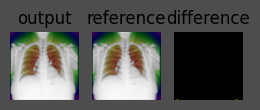

 ==============Case4==============
 -----output----- ----expected----
      1.6580           0.0000     


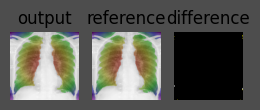

 ==============Case5==============
 -----output----- ----expected----
      2.2038           0.0000     


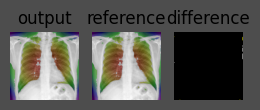

 ==============Case6==============
 -----output----- ----expected----
      3.2026           0.0000     


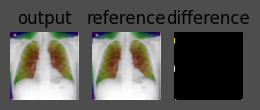

 ==============Case7==============
 -----output----- ----expected----
      0.0000           0.0000     


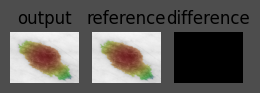

 ==============Case8==============
 -----output----- ----expected----
      1.7522           0.0000     


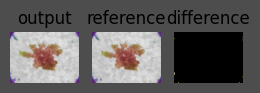

 ==============Case9==============
 -----output----- ----expected----
      0.0893           0.0000     


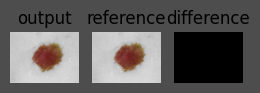

 =============Case10==============
 -----output----- ----expected----
      5.7381           0.0000     


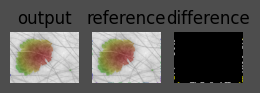

 =============Case11==============
 -----output----- ----expected----
      0.0000           0.0000     


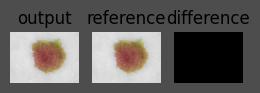

 =============Case12==============
 -----output----- ----expected----
      0.0000           0.0000     


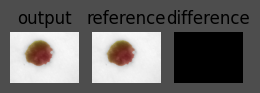

 3/12


In [45]:
import matplotlib.pyplot as plt

print_output: bool = True
show_images: bool = True

correct = 0
for i in range(1,13):
    filename: str = f"Case{i}"
    output, mixed_image, ref_image = main(f"in/{filename}.in")
    expected = float(open(f"out/{filename}.out").readline())
    passed: bool = (output == expected)

    text_color = '\033[0m'
    if passed:
        text_color = '\033[92m'
    else:
        text_color = '\033[91m'

    correct += passed

    print(text_color + f" {filename:=^{33 if print_output else 0}}" + '\033[0m')
    if(print_output):
        print(f" {'output':-^16} {'expected':-^16}")
        print(f" {output:^16.4f} {expected:^16.4f}")

        if(show_images):
            total_size: float = 3
            fig, axes = plt.subplots(1, 3, figsize = (total_size,total_size))
            fig.set_facecolor((0.3,0.3,0.3))
            axes[0].imshow(mixed_image)
            axes[0].title.set_text("output")
            axes[0].axis("off")
            axes[1].imshow(ref_image)
            axes[1].title.set_text("reference")
            axes[1].axis("off")
            # diff: np.ndarray = np.logical_xor(mixed_image, ref_image)
            # print(np.sum(diff))
            diff: np.ndarray = ref_image - mixed_image
            diff[diff != 0] = 255
            axes[2].imshow(diff)
            axes[2].title.set_text("difference")
            axes[2].axis("off")
            plt.show()

print(f" {correct}/12")
